---
title: OSM Strategies
date-format: long
date-modified: last-modified
lang: en
language:
  title-block-modified: "Last update"
---


Install and update `cityseer` if necessary.


In [1]:
# !pip install --upgrade cityseer

See the [guide](https://cityseer.benchmarkurbanism.com/guide) for a preamble.

Please also see the [`graph cleaning`](https://cityseer.benchmarkurbanism.com/guide#graph-cleaning) guide for additional information on the graph cleaning approach.

This notebook uses OSM data to compare three strategies for network preparation and then compares the centralities computed on each:

1. Algorithmically cleaning and consolidating the network
2. Using a minimally cleaned network which strips out unnecessary nodes but doesn't apply any consolidation methods.
3. Using a minimally cleaned network but with corrections for network distortions through edge "dissolving" and "jitter".

### Preparing the data extents


In [2]:
import matplotlib.pyplot as plt
from cityseer import rustalgos
from cityseer.metrics import networks
from cityseer.tools import graphs, io, plot

# download from OSM
lng, lat = -0.13396079424572427, 51.51371088849723
buffer = 5000
distances = [250, 500, 1000, 2000]
# creates a WGS shapely polygon
poly_wgs, _ = io.buffered_point_poly(lng, lat, buffer)
poly_utm, _ = io.buffered_point_poly(lng, lat, buffer, projected=True)

### Automatic cleaning

This approach prepares a network using automated algorithmic cleaning methods to consolidate complex intersections and parallel roads.


In [3]:
G_utm = io.osm_graph_from_poly(poly_wgs, simplify=True)
# decompose for higher resolution analysis
G_decomp = graphs.nx_decompose(G_utm, 25)
# prepare data structures
nodes_gdf, _edges_gdf, network_structure = io.network_structure_from_nx(
    G_decomp, crs=32629
)
# compute centralities
# if computing wider area centralities, e.g. 20km, then use less decomposition to speed up the computation
nodes_gdf = networks.node_centrality_shortest(
    network_structure=network_structure,
    nodes_gdf=nodes_gdf,
    distances=distances,
)

INFO:cityseer.tools.io:Converting networkX graph from EPSG code 4326 to EPSG code 32630.
INFO:cityseer.tools.io:Processing node x, y coordinates.
100%|██████████| 162040/162040 [00:00<00:00, 438072.54it/s]
INFO:cityseer.tools.io:Processing edge geom coordinates, if present.
100%|██████████| 178697/178697 [00:00<00:00, 896442.79it/s]
INFO:cityseer.tools.graphs:Generating interpolated edge geometries.
100%|██████████| 178697/178697 [00:02<00:00, 68445.93it/s]
INFO:cityseer.tools.graphs:Removing filler nodes.
100%|██████████| 162040/162040 [00:25<00:00, 6312.45it/s]
INFO:cityseer.tools.graphs:Removing dangling nodes.
100%|██████████| 51555/51555 [00:00<00:00, 237584.81it/s]
INFO:cityseer.tools.graphs:Removing filler nodes.
100%|██████████| 44904/44904 [00:01<00:00, 38113.22it/s]
INFO:cityseer.tools.util:Creating edges STR tree.
100%|██████████| 58891/58891 [00:00<00:00, 415163.92it/s]
INFO:cityseer.tools.graphs:Splitting opposing edges.
100%|██████████| 41511/41511 [00:00<00:00, 123098.74

### Minimal cleaning

This method performs minimal cleaning and is used for reference point for the other two methods.


In [4]:
# generate OSM graph from polygon - note no automatic simplification applied
G_utm_minimal = io.osm_graph_from_poly(poly_wgs, simplify=False)
# decompose for higher resolution analysis
G_decomp_minimal = graphs.nx_decompose(G_utm_minimal, 25)
# prepare data structures
(
    nodes_gdf_minimal,
    _edges_gdf_minimal,
    network_structure_minimal,
) = io.network_structure_from_nx(G_decomp_minimal, crs=32629)
# compute centrality
nodes_gdf_minimal = networks.node_centrality_shortest(
    network_structure=network_structure_minimal,
    nodes_gdf=nodes_gdf_minimal,
    distances=distances,
)

INFO:cityseer.tools.io:Converting networkX graph from EPSG code 4326 to EPSG code 32630.
INFO:cityseer.tools.io:Processing node x, y coordinates.
100%|██████████| 162040/162040 [00:00<00:00, 457123.94it/s]
INFO:cityseer.tools.io:Processing edge geom coordinates, if present.
100%|██████████| 178697/178697 [00:00<00:00, 864159.28it/s]
INFO:cityseer.tools.graphs:Generating interpolated edge geometries.
100%|██████████| 178697/178697 [00:03<00:00, 57340.84it/s]
INFO:cityseer.tools.graphs:Removing filler nodes.
100%|██████████| 162040/162040 [00:20<00:00, 7799.77it/s]
INFO:cityseer.tools.graphs:Decomposing graph to maximum edge lengths of 25.
100%|██████████| 70562/70562 [00:24<00:00, 2845.60it/s]
INFO:cityseer.tools.io:Preparing node and edge arrays from networkX graph.
100%|██████████| 124895/124895 [00:19<00:00, 6558.34it/s]
INFO:cityseer.metrics.networks:Computing shortest path node centrality.
100%|██████████| 124895/124895 [07:21<00:00, 282.76it/s]


### Dissolving network weights

This approach doesn't attempt to consolidate the network. Instead, it uses techniques to control for messy network representations:

- It "dissolves" network weights - meaning that nodes representing street segments which are likely duplicitous are weighted less heavily.
- It injects "jitter" to derive more intuitively consistent network routes.


In [5]:
# generate dissolved weights
G_dissolved_wts = graphs.nx_weight_by_dissolved_edges(G_decomp_minimal, max_ang_diff=25)
# prepare data structures
(
    nodes_gdf_dissolved,
    _edges_gdf_dissolved,
    network_structure_dissolved,
) = io.network_structure_from_nx(G_dissolved_wts, crs=32629)
# compute centralities
nodes_gdf_dissolved = networks.node_centrality_shortest(
    network_structure=network_structure_dissolved,
    nodes_gdf=nodes_gdf_dissolved,
    distances=distances,
    jitter_scale=10,
)

INFO:cityseer.tools.graphs:Generating node weights based on locally dissolved edges using a buffer of 20m.
INFO:cityseer.tools.util:Creating edges STR tree.
100%|██████████| 124895/124895 [00:04<00:00, 27325.22it/s]
INFO:cityseer.tools.io:Preparing node and edge arrays from networkX graph.
100%|██████████| 124895/124895 [00:21<00:00, 5874.57it/s]
INFO:cityseer.metrics.networks:Computing shortest path node centrality.
100%|██████████| 124895/124895 [05:28<00:00, 380.78it/s]


### Plots

Compares a selection of distance thresholds for each approach.


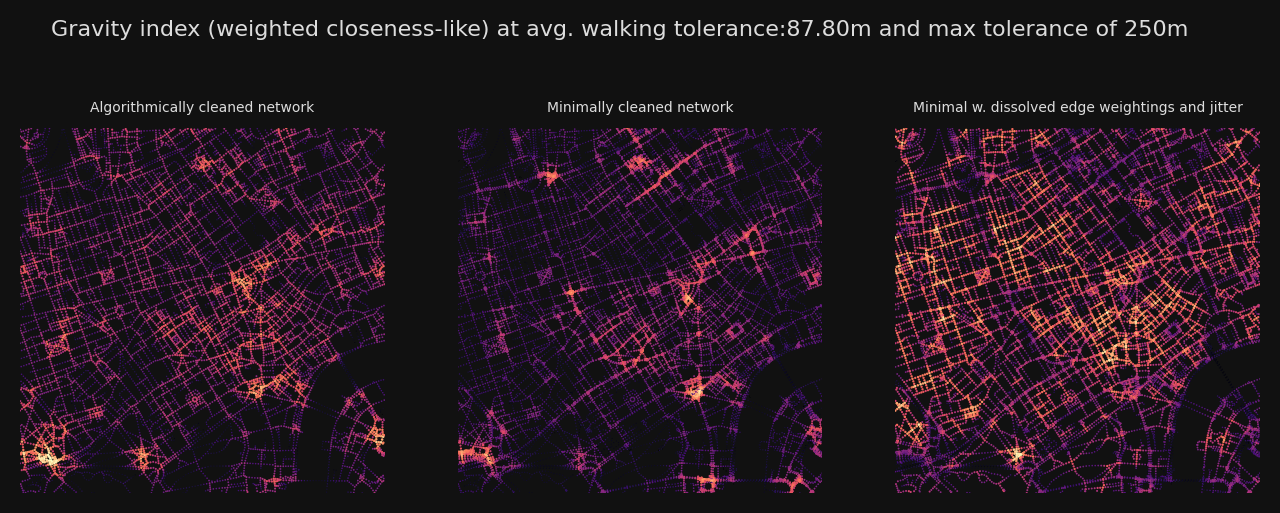

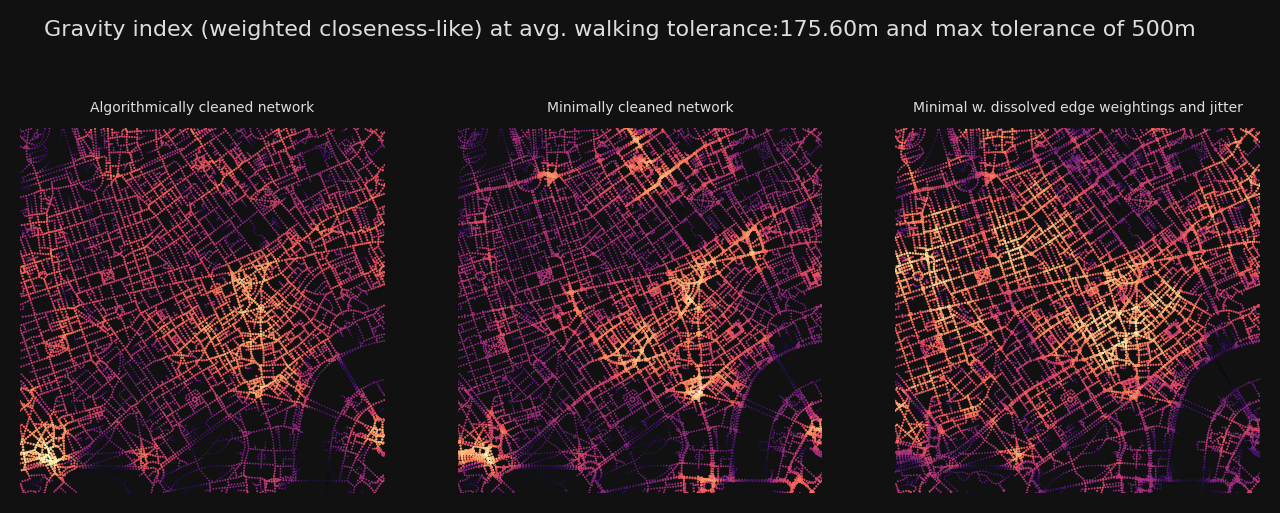

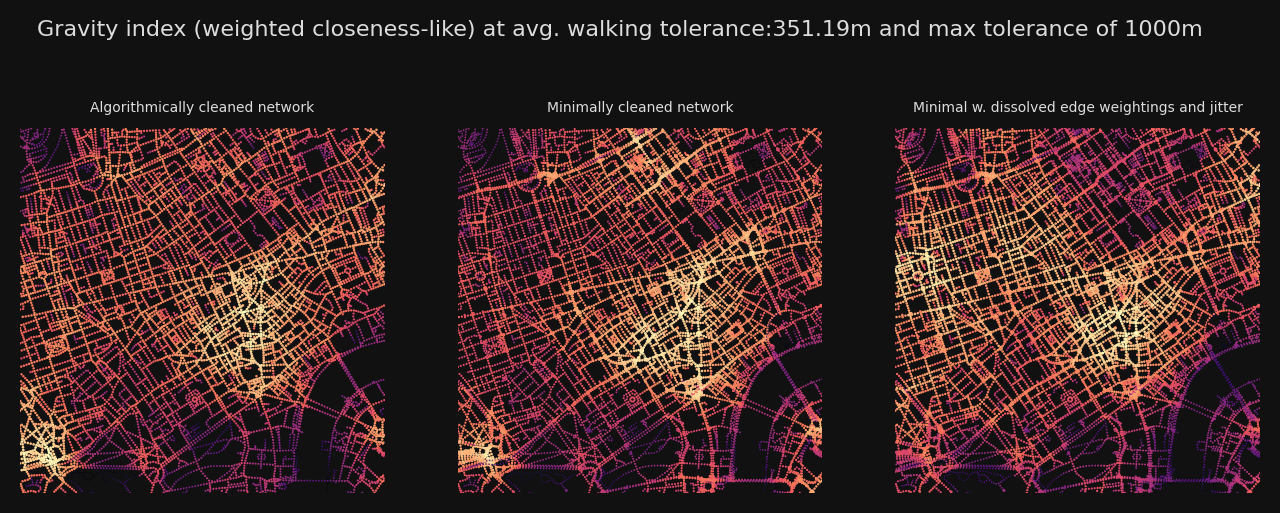

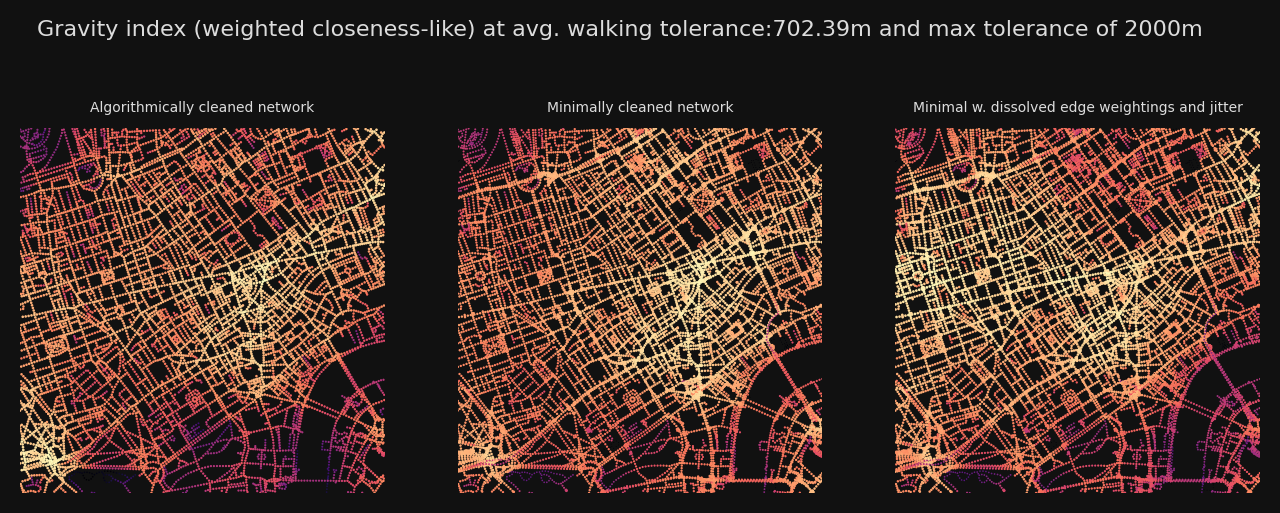

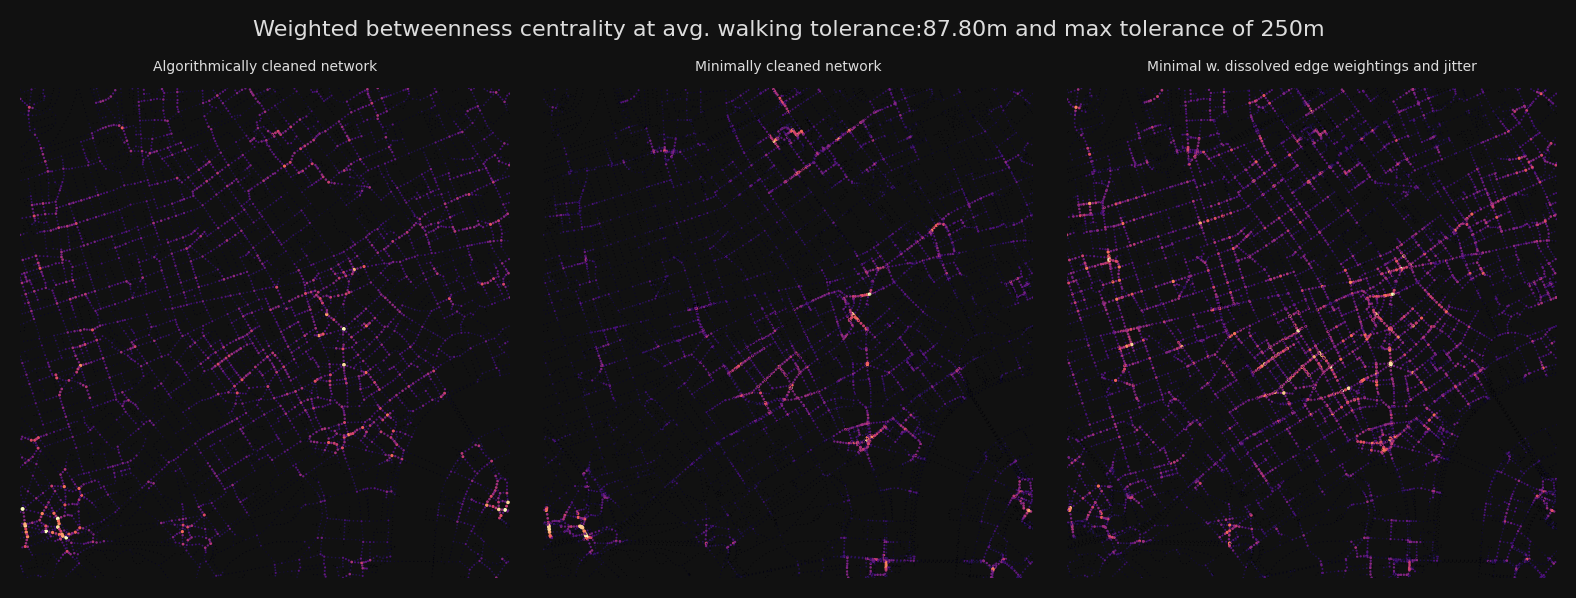

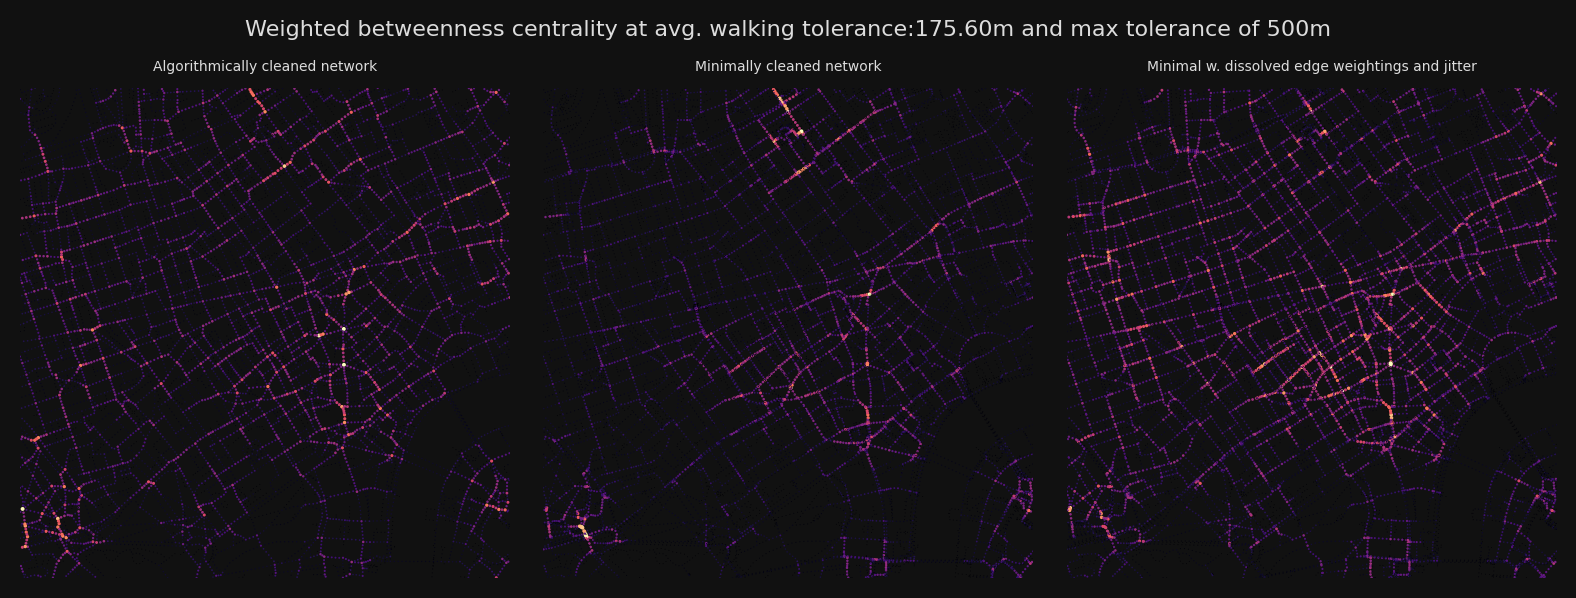

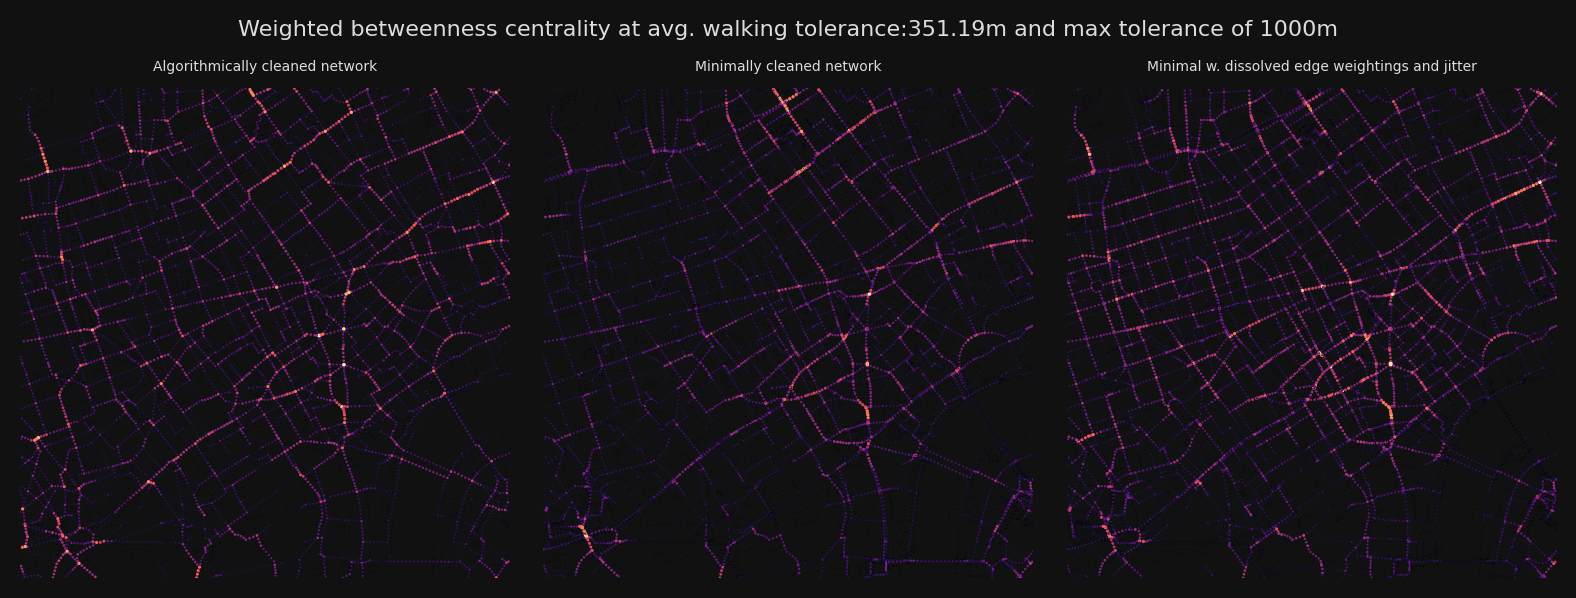

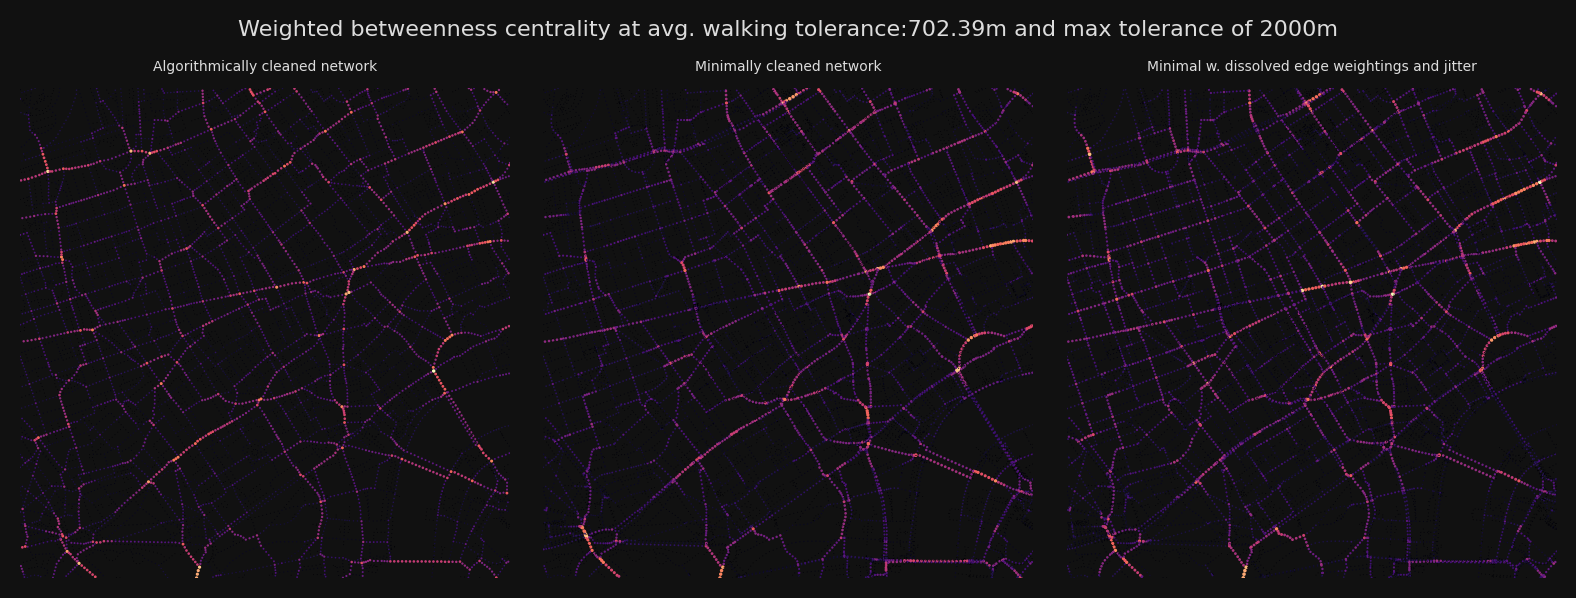

In [6]:
bg_colour = "#111"
betas = rustalgos.betas_from_distances(distances)
avg_dists = rustalgos.avg_distances_for_betas(betas)
plot_bbox = poly_utm.centroid.buffer(1500).bounds
bg_colour = "#111"
text_colour = "#ddd"
font_size = 5
for d, b, avg_d in zip(distances, betas, avg_dists):
    fig, axes = plt.subplots(1, 3, figsize=(8, 3), dpi=200, facecolor=bg_colour)
    fig.suptitle(
        f"Gravity index (weighted closeness-like) at avg. walking tolerance:{avg_d:.2f}m and max tolerance of {d}m",
        color=text_colour,
        fontsize=8,
    )
    plot.plot_scatter(
        axes[0],
        network_structure.node_xs,
        network_structure.node_ys,
        nodes_gdf[f"cc_beta_{d}"],
        bbox_extents=plot_bbox,
        cmap_key="magma",
        face_colour=bg_colour,
    )
    axes[0].set_title(
        "Algorithmically cleaned network", fontsize=font_size, color=text_colour
    )
    plot.plot_scatter(
        axes[1],
        network_structure_minimal.node_xs,
        network_structure_minimal.node_ys,
        nodes_gdf_minimal[f"cc_beta_{d}"],
        bbox_extents=plot_bbox,
        cmap_key="magma",
        face_colour=bg_colour,
    )
    axes[1].set_title(
        "Minimally cleaned network", fontsize=font_size, color=text_colour
    )
    plot.plot_scatter(
        axes[2],
        network_structure_dissolved.node_xs,
        network_structure_dissolved.node_ys,
        nodes_gdf_dissolved[f"cc_beta_{d}"],
        bbox_extents=plot_bbox,
        cmap_key="magma",
        face_colour=bg_colour,
    )
    axes[2].set_title(
        "Minimal w. dissolved edge weightings and jitter",
        fontsize=font_size,
        color=text_colour,
    )
    plt.show()

for d, b, avg_d in zip(distances, betas, avg_dists):
    fig, axes = plt.subplots(1, 3, figsize=(8, 3), dpi=200, facecolor=bg_colour)
    fig.suptitle(
        f"Weighted betweenness centrality at avg. walking tolerance:{avg_d:.2f}m and max tolerance of {d}m",
        color=text_colour,
        fontsize=8,
    )
    plot.plot_scatter(
        axes[0],
        network_structure.node_xs,
        network_structure.node_ys,
        nodes_gdf[f"cc_betweenness_{d}"],
        bbox_extents=plot_bbox,
        cmap_key="magma",
        s_max=2,
        face_colour=bg_colour,
    )
    axes[0].set_title(
        "Algorithmically cleaned network", fontsize=font_size, color=text_colour
    )
    plot.plot_scatter(
        axes[1],
        network_structure_minimal.node_xs,
        network_structure_minimal.node_ys,
        nodes_gdf_minimal[f"cc_betweenness_{d}"],
        bbox_extents=plot_bbox,
        cmap_key="magma",
        s_max=2,
        face_colour=bg_colour,
    )
    axes[1].set_title(
        "Minimally cleaned network", fontsize=font_size, color=text_colour
    )
    plot.plot_scatter(
        axes[2],
        network_structure_dissolved.node_xs,
        network_structure_dissolved.node_ys,
        nodes_gdf_dissolved[f"cc_betweenness_{d}"],
        bbox_extents=plot_bbox,
        cmap_key="magma",
        s_max=2,
        face_colour=bg_colour,
    )
    axes[2].set_title(
        "Minimal w. dissolved edge weightings and jitter",
        fontsize=font_size,
        color=text_colour,
    )
    plt.tight_layout()
    plt.show()